EP03 - Visão e Processamento de Imagens
===

Nº USP | Nome
---|---|
11347794|Aarão Melo Lopes|

---

## Acesso


Se estiver utilizando o Google Colaboratory execute os passos a seguir. No entanto, se estiver rodando em um dispositivo local, ignore esta seção.


Realize login com sua conta google, para ter acesso aos arquivos compartilhados, executando a célula abaixo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mude o diretório corrente para a pasta do projeto.

In [ ]:
cd drive/Shared drives/EP03 - Visão e Processamento de Imagens

/content/drive/Shared drives/EP03 - Visão e Processamento de Imagens


## Segmentação

  Nesta seção discorreremos sobre a segmentação de nossas imagens. Foram aplicados diversos métodos de segmaentação de imagens, afim de, separar o objeto de interesse do plano de fundo, tal como a transformada slic para segmentação de superpíxel, com o objetivo de reduzir a dimensionalidade das entradas, seguida de uma classificação baseada em redes de markov para separar o objeto do fundo. No entanto, essa abordagem não se mostrou satisfatória, devido ao tempo de execução e o resultado ineficaz da classificacão.

  Desta forma, optamos por seguimentar todas as imagens de interesse manualmente com auxílio do software Gimp e sua ferramenta de seleção livre. Assim, segmentamos 180 imagens (18 amostras para cada classe), que corresponde à 16,6% do nosso banco de imagens (1080 imagens). O resultado da segmentação pode ser visto com auxílio das duas células seguintes. 

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave

def loadDir(path):
  dataset = []
  for i in range(180):
    dataset.append(imread(path+"/" + str(i+1) + '.jpeg'))
  return dataset

def showimages(image_list):
  for j in range(10):
    fig, axes = plt.subplots(1, 18, figsize=(20, 20))
    ax = axes.ravel()
    for i in range(18):
        ax[i].imshow(image_list[i+j*18])
        ax[i].axis('off')
    fig.tight_layout()
    plt.show()

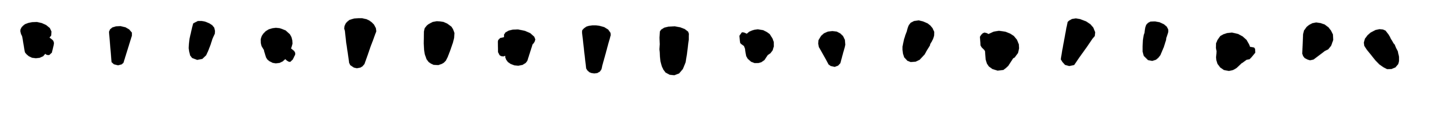

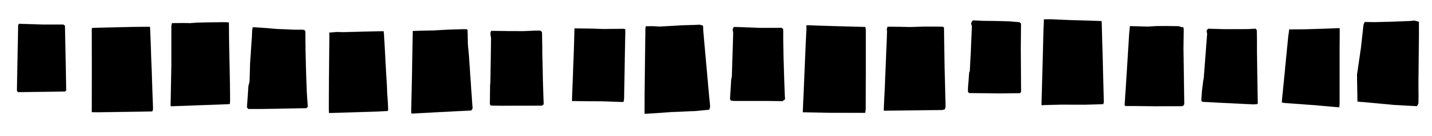

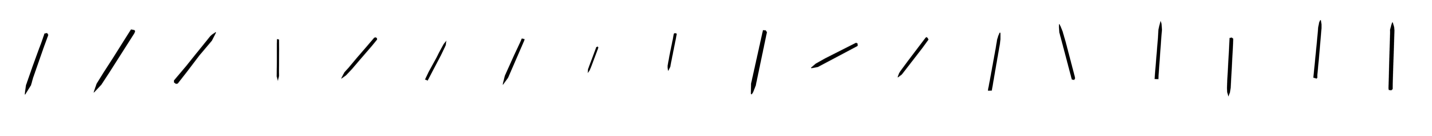

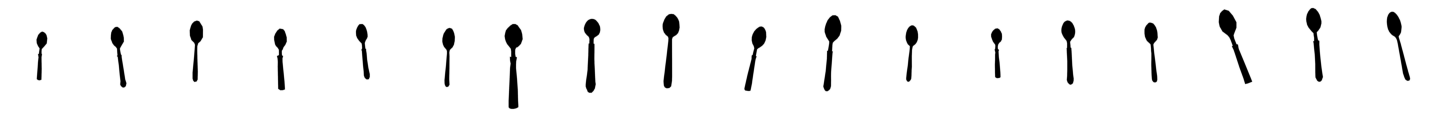

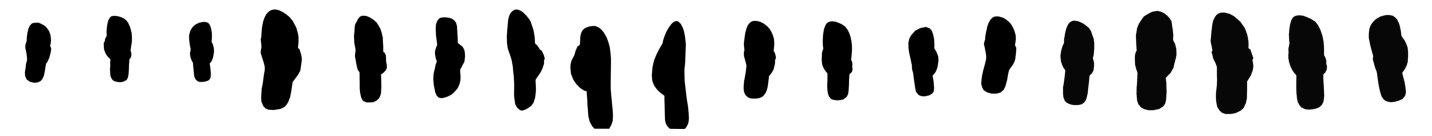

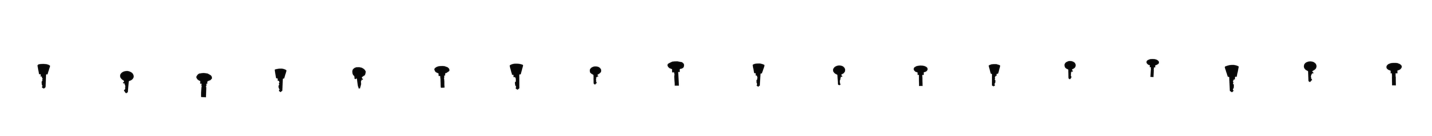

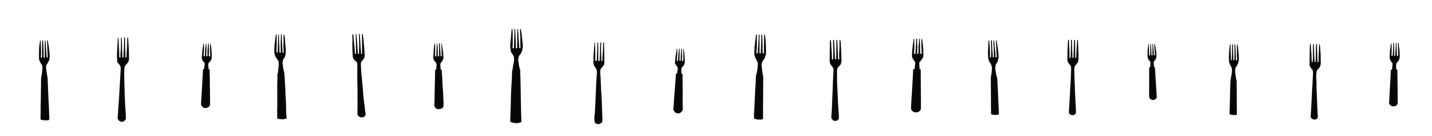

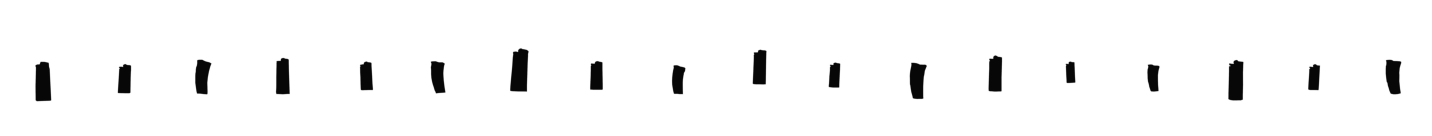

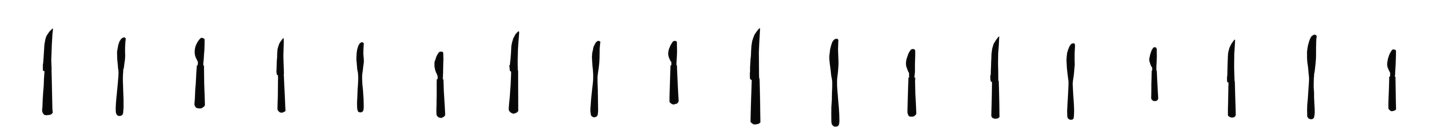

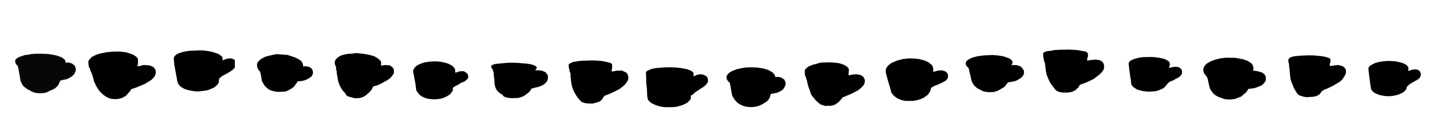

In [ ]:
showimages(loadDir("seg_images"))

Após algum esforço, obtemos uma ótima segmentação manual das imagens (como é de se esperar). No entanto, ao salvar as imagens binárias no formato jpeg, foi introduzido um ruído devido ao método de compactação com perdas do formato em questão, o que pode introduzir consideráveis discrepâncias entre os valores de área e perímetro calculados e o valor real dessas grandezas.

Portanto, a célula abaixo tem a função segmentar novamente as amostras através do contorno dos objetos e salvá-las em formato de texto para que não haja introdução de novos ruídos que podem comprometer seriamente o desempenho da etapa seguinte de classificação.

In [ ]:
from skimage.io import imread, imshow
import numpy as np
import cv2 as cv

for k in range(180):
  image = cv.imread("seg_images/" + str(k+1) + '.jpeg')
  imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  ret, thresh = cv.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
  contour = cv.drawContours(np.uint8([[[0,0,0] for j in range(720)] for i in range(1280)]), contours, -1, [255,255,255], -100)
  image_f = [[[255,255,255] for j in range(720)] for i in range(1280)]
  
  d = 10
  for i in range(1280-d):
    for j in range(720-d):
      image_f[i+d//2][j+d//2][0] = contour[i+d//2][j+d//2][0]
      image_f[i+d//2][j+d//2][1] = contour[i+d//2][j+d//2][1]
      image_f[i+d//2][j+d//2][2] = contour[i+d//2][j+d//2][2]

  matrix_binary = [[0 for j in range(720)] for i in range(1280)]
  for i in range(1280):
    for j in range(720):
      if (image_f[i][j][0] == 0):
        matrix_binary[i][j] = 1
  np.savetxt("seg_images_array/"+str(k+1)+".txt", matrix_binary, newline='\n')
  print('save ' + str(k+1)+".txt")

In [ ]:
image_binary_list = []
for i in range(180):
  image_binary_list.append(np.loadtxt('seg_images_array/' + str(i+1)+".txt"))
  print('open ' + str(i+1)+".txt")

A célula abaixo tem a função de obter as bounding-boxes de cada objeto em cada amostra.

In [ ]:
for k in range(180):
  i_min = 1279
  i_max = 0
  j_min = 719
  j_max = 0
  for i in range(1280):
    for j in range(720):
      if (image_binary_list[k][i][j] == 1):
        if i < i_min:
          i_min = i
        if i > i_max:
          i_max = i
        if j < j_min:
          j_min = j
        if j > j_max:
          j_max = j
  di = i_max-i_min
  dj = j_max-j_min
  boundingbox_image = [[0 for j in range(dj+2)] for i in range(di+2)]
  for i in range(di-1):
    for j in range(dj-1):
      boundingbox_image[i+1][j+1] = image_binary_list[k][i+i_min][j+j_min] 
  np.savetxt("boundingbox_images/"+str(k+1)+".txt", boundingbox_image, newline='\n')
  print('save ' + str(k+1)+".txt")


In [ ]:
import numpy as np
image_boundingbox_list = []
for i in range(180):
  image_boundingbox_list.append(np.loadtxt('boundingbox_images/' + str(i+1)+".txt"))
  print('open ' + str(i+1)+".txt")

A célula abaixo calcula a área de cada objeto.

In [ ]:
area_array = []
for k in range(180):
  area = 0
  lines = len(image_boundingbox_list[k])
  columns = len(image_boundingbox_list[k][0])
  for i in range(lines):
    for j in range(columns):
      area += image_boundingbox_list[k][i][j]
  area_array.append(area)
  print('area ' + str(k+1))

A célula abaixo calcula o perímetro de cada objeto.

In [ ]:
perimeter_array =[]
for k in range(180):
  perimeter = 0
  lines = len(image_boundingbox_list[k])
  columns = len(image_boundingbox_list[k][0])

  for i in range(lines-1):
    for j in range(columns-1):
      if image_boundingbox_list[k][i+1][j+1] == 1:
        neighbor_black = False
        neighbor_white = False
        for m in [-1,0,1]:
          for n in [-1,0,1]:
            if not ((m==0) and (n==0)):
              if image_boundingbox_list[k][i+1+m][j+1+n] == 0:
                neighbor_black = True
              else:
                neighbor_white = True
        if neighbor_black and neighbor_white:
          perimeter += 1
  perimeter_array.append(perimeter)
  print('perimeter ' + str(k+1))


In [ ]:
area_object_array = []
perimeter_object_array = []
for k in list(range(18, 181, 18)):
  area_object = []
  perimeter_object = []
  for i in list(range(k-18,k,1)):
    area_object.append(area_array[i])
    perimeter_object.append(perimeter_array[i])
  area_object_array.append(area_object)
  perimeter_object_array.append(perimeter_object)
np.savetxt("area/area_abs.txt", area_object_array, newline='\n')
np.savetxt("perimeter/perimeter_abs.txt", perimeter_object_array, newline='\n')

## Classificador Bayesiano







In [ ]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np
def plot_classes(X,Y):
  labels = ["copo", "livro", "caneta", "colher", "chinelo", "chave", "garfo", "isqueiro", "faca", "xicara"]
  fig = plt.figure()
  ax = fig.add_subplot(111)
  for x,y,lab in zip(X,Y,labels):
    ax.scatter(x,y,label=lab)
  colormap = plt.cm.gist_ncar 
  colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
  for t,j1 in enumerate(ax.collections):
      j1.set_color(colorst[t])
  ax.legend(fontsize='small')

In [ ]:
area = np.loadtxt("area/area_abs.txt")
perimeter = np.loadtxt("perimeter/perimeter_abs.txt")

A célula abaixo mostra o gráfico de todas nossas 10 classes, podemos ver que estão rezoavelmente bem seperadas, dado nosso vetor de características que tem apenas dimensão 2. 

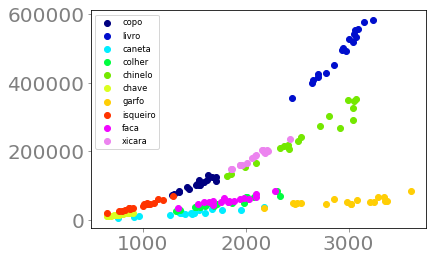

In [ ]:
 plot_classes(perimeter, area)

### Médias e covariâncias

In [ ]:
samples = [[np.array([[0,0]]) for j in range(18)] for i in range(10)]
for i in range(10):
  for j in range(18):
    samples[i][j] = np.array([[perimeter[i][j],area[i][j]]])

Calculamos uma estimativa do vetor médio e da matriz de covariância de cada classe:

$$\textbf{m}_j=\frac{1}{N_j}\sum_{\textbf{x}\in\omega_j}\textbf{x}$$
e
$$ \textbf{C}_j=\frac{1}{N_j} \sum_{\textbf{x}\in \omega)j}\textbf{x}\textbf{x}^T-\textbf{m}_j\textbf{m}_j^T $$

sendo que $N_j$ é o número de vetores de características da classe $N_j$, e a soma é feita sobre esses vetores.

In [ ]:
means = [np.array([[0,0]]) for i in range(10)]
for i in range(10):
  for j in range(18):
    means[i] = np.add(means[i],samples[i][j])
  means[i] = np.divide(means[i],18)


In [ ]:
covariances = [np.array([[0,0],[0,0]]) for i in range(10)]
for i in range(10):
  for j in range(18):
    covariances[i] = np.add(covariances[i], np.subtract( np.dot(samples[i][j].T,samples[i][j]), np.dot(means[i].T,means[i])  ) )
  covariances[i] = np.divide(covariances[i],18)

A Equação abaixo representa as funções de decisão bayesianas para classes equiprováveis de padrão gaussiano sob a condição de função de perda 0-1.

$$ d_j(\textbf{x})=\left|\textbf{C}_j\right|+(\textbf{x}-\textbf{m}_j)^T\textbf{C}_j^{-1}(\textbf{x}-\textbf{m}_j) $$

In [ ]:
import math
def decision_function(sample,classId):
  subtract = np.subtract(sample,means[classId])
  return (
      math.log(np.linalg.det(covariances[classId])) +
      np.dot(  np.dot(subtract, np.linalg.inv(covariances[classId])) , np.transpose(subtract))
    )

In [ ]:
array_class_decision = [[[ 0 for k in range(10)] for j in range(18)] for i in range(10)]
for i in range(10):
  for j in range(18):
    for k in range(10):
      array_class_decision[i][j][k] = decision_function(samples[i][j],k)

Para cada amostra, atribuímos a classe que fornece a menor perda ou maior probabilidade de ocorrência.

In [ ]:
array_class_max_prob = [[ 0 for j in range(18)] for i in range(10)]
array_class = [[ 0 for j in range(18)] for i in range(10)]
for i in range(10):
  for j in range(18):
    array_class[i][j] = i*18+j
    array_class_max_prob[i][j] = np.argmin( array_class_decision[i][j] )

A gráfico abaixo mostra a classificação das mesmas amostras que usamos para treinar o sistema. Obtemos um padrão muito próximo ao ideal, que seria um padrão em escada.

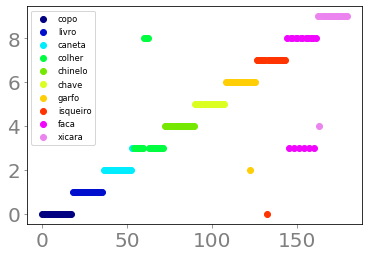

In [ ]:
 plot_classes(array_class, array_class_max_prob)

In [ ]:
array_class_max_prob

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
 [3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6],
 [7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8],
 [9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]

A tabela abaixo fornece a porcentagem de acertos para cada classe.

Classe/Classificação por classe|1|2|3|4|5|6|7|8|9|10|Corretas(%)
-|-|-|-|-|-|-|-|-|-|-|-|
1 - copo|18|0|0|0|0|0|0|0|0|0|100
2 - livro|0|18|0|0|0|0|0|0|0|0|100
3 - caneta|0|0|17|1|0|0|0|0|0|0|94,9
4 - colher|0|0|0|15|0|0|0|0|3|0|83,3
5 - chinelo|0|0|0|0|18|0|0|0|0|0|100
6 - chave|0|0|0|0|0|18|0|0|0|0|100
7 - garfo|0|0|1|0|0|0|17|0|0|0|94,9
8 - isqueiro|1|0|0|0|0|0|0|17|0|0|94,9
9 - faca|0|0|0|6|0|0|0|0|12|0|66,6
10 - xicara|0|0|0|0|1|0|0|0|0|17|94,9


Dado o exposto, podemos considerar que nossa classificação foi satisfatória dadas as técnicas que aplicamos. Obtemos um acerto global de:
$$\frac{18+18+17+15+18+18+17+17+12+17}{180}=92,8\%.$$